In [ ]:
!pip install transformers sentencepiece
VERSION = "1.8.1"
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

In [ ]:
import shutil
import os
from glob import glob

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    DistilBertTokenizerFast,
    XLNetTokenizer,
    XLNetForSequenceClassification,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)

In [ ]:
def data_read(data_path):
    data = []
    for file_name in glob(data_path):
        with open(file_name) as f:
            tmp_data = f.read()
            data.extend(tmp_data.split('\n'))
    return data

In [ ]:
path_formal = 'GYAFC_Corpus/*/{}/formal*'
path_inform = 'GYAFC_Corpus/*/{}/informal*'

In [ ]:
file_path = 'GYAFC_Corpus.7z'
if not os.path.isfile(file_path):
    !wget -O GYAFC_Corpus.7z "https://docs.google.com/uc?export=download&id=18KvT3MHnKtlHcFyna0044CxNbdgOLJXU"
    !7z x GYAFC_Corpus.7z

In [ ]:
data_train_form = data_read(path_formal.format('train'))
data_train_inform = data_read(path_inform.format('train'))

data_valid_form = data_read(path_formal.format('test'))
data_valid_inform = data_read(path_inform.format('test'))

data_test_form = data_read(path_formal.format('tune'))
data_test_inform = data_read(path_inform.format('tune'))

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

In [ ]:
def prep_dataset(formal, informal):
    tuples = []
    data = []
    labels = []
    formal = list(set(formal))
    for sentence in formal:
        data.append(sentence)
        labels.append(0)
    informal = list(set(informal))
    for sentence in informal:
        data.append(sentence)
        labels.append(1)
    return data, labels

In [ ]:
train_texts, train_labels = prep_dataset(data_train_form, data_train_inform)
val_texts, val_labels = prep_dataset(data_valid_form, data_valid_inform)
test_texts, test_labels = prep_dataset(data_test_form, data_test_inform)

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=24)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=24)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=24)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


In [ ]:
import torch_xla.distributed.xla_multiprocessing as xmp

In [ ]:
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = 2)
# model.eval()

WRAPPED_MODEL = xmp.MpModelWrapper(model)

In [ ]:
class Formal_informal(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    """
    Compute metrics for Trainer
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    #_, _, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")

    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        #'macro f1': macro_f1,
        'precision': precision,
        'recall': recall
    }

def train_nli(model, epochs=10, warmup_steps=200):
    """
    This contains everything that must be done to train our models
    """

    print("Loading datasets... ", end="")
    train_dataset = Formal_informal(train_encodings, train_labels)
    val_dataset = Formal_informal(val_encodings, val_labels)
    test_dataset = Formal_informal(test_encodings, test_labels)

    training_args = TrainingArguments(
        output_dir='./results',          # output directory
        num_train_epochs=3,              # total number of training epochs
        per_device_train_batch_size=16,  # batch size per device during training
        per_device_eval_batch_size=64,   # batch size for evaluation
        warmup_steps=500,                # number of warmup steps for learning rate scheduler
        weight_decay=0.01,               # strength of weight decay
        logging_dir='./logs',            # directory for storing logs
        logging_steps=500,
        evaluation_strategy = 'steps',
        load_best_model_at_end=True,
        metric_for_best_model="f1",
    )

    results = []

    trainer = Trainer(
        model=model,                         # the instantiated 🤗 Transformers model to be trained
        args=training_args,                  # training arguments, defined above
        train_dataset=train_dataset,         # training dataset
        eval_dataset=val_dataset,             # evaluation dataset
        compute_metrics=compute_metrics
    )
    trainer.place_model_on_device = False
    trainer.train()

    trainer.save_model("nli_model/")
    tokenizer.save_pretrained("nli_model/")

In [ ]:
!rm -R logs
!rm -R results

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

In [ ]:
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp

In [ ]:
def _mp_fn(index):
    device = xm.xla_device()
    # We wrap this 
    model = WRAPPED_MODEL.to(device)

    train_nli(model)

xmp.spawn(_mp_fn, start_method="fork")

***** Running training *****
  Num examples = 209128
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 9804


Loading datasets... 

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.381700,0.836314,0.846075,0.838160,0.881682,0.833720
1000,0.299500,0.437596,0.885926,0.882960,0.899074,0.878815
1500,0.268800,0.350168,0.884360,0.881221,0.898508,0.876967
2000,0.289300,0.367807,0.891613,0.889442,0.899639,0.886071
2500,0.257900,0.408614,0.894869,0.892944,0.901567,0.889836
3000,0.251900,0.369992,0.891737,0.889804,0.897949,0.886816
3500,0.231500,0.367093,0.896476,0.894769,0.901759,0.891994
4000,0.218100,0.436593,0.888687,0.886108,0.899356,0.882294
4500,0.230100,0.416772,0.893509,0.891789,0.898431,0.889114
5000,0.234000,0.476956,0.893592,0.891602,0.900558,0.888441


Loading datasets... 

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.378500,0.836314,0.846075,0.838160,0.881682,0.833720
1000,0.309700,0.437596,0.885926,0.882960,0.899074,0.878815
1500,0.274300,0.350168,0.884360,0.881221,0.898508,0.876967
2000,0.273100,0.367807,0.891613,0.889442,0.899639,0.886071
2500,0.274200,0.408614,0.894869,0.892944,0.901567,0.889836
3000,0.244900,0.369992,0.891737,0.889804,0.897949,0.886816
3500,0.249600,0.367093,0.896476,0.894769,0.901759,0.891994
4000,0.212100,0.436593,0.888687,0.886108,0.899356,0.882294
4500,0.221800,0.416772,0.893509,0.891789,0.898431,0.889114
5000,0.225400,0.476956,0.893592,0.891602,0.900558,0.888441


Loading datasets... 

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.373200,0.836314,0.846075,0.838160,0.881682,0.833720
1000,0.308000,0.437596,0.885926,0.882960,0.899074,0.878815
1500,0.269600,0.350168,0.884360,0.881221,0.898508,0.876967
2000,0.271500,0.367807,0.891613,0.889442,0.899639,0.886071
2500,0.274200,0.408614,0.894869,0.892944,0.901567,0.889836
3000,0.250500,0.369992,0.891737,0.889804,0.897949,0.886816
3500,0.261900,0.367093,0.896476,0.894769,0.901759,0.891994
4000,0.261100,0.436593,0.888687,0.886108,0.899356,0.882294
4500,0.248600,0.416772,0.893509,0.891789,0.898431,0.889114
5000,0.198000,0.476956,0.893592,0.891602,0.900558,0.888441


Loading datasets... 

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.384800,0.836314,0.846075,0.838160,0.881682,0.833720
1000,0.306300,0.437596,0.885926,0.882960,0.899074,0.878815
1500,0.264400,0.350168,0.884360,0.881221,0.898508,0.876967
2000,0.282000,0.367807,0.891613,0.889442,0.899639,0.886071
2500,0.285900,0.408614,0.894869,0.892944,0.901567,0.889836
3000,0.276000,0.369992,0.891737,0.889804,0.897949,0.886816
3500,0.251700,0.367093,0.896476,0.894769,0.901759,0.891994
4000,0.236600,0.436593,0.888687,0.886108,0.899356,0.882294
4500,0.233400,0.416772,0.893509,0.891789,0.898431,0.889114
5000,0.239000,0.476956,0.893592,0.891602,0.900558,0.888441


Loading datasets... 

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.377200,0.836314,0.846075,0.838160,0.881682,0.833720
1000,0.270800,0.437596,0.885926,0.882960,0.899074,0.878815
1500,0.313100,0.350168,0.884360,0.881221,0.898508,0.876967
2000,0.268600,0.367807,0.891613,0.889442,0.899639,0.886071
2500,0.260700,0.408614,0.894869,0.892944,0.901567,0.889836
3000,0.269600,0.369992,0.891737,0.889804,0.897949,0.886816
3500,0.245700,0.367093,0.896476,0.894769,0.901759,0.891994
4000,0.236800,0.436593,0.888687,0.886108,0.899356,0.882294
4500,0.210300,0.416772,0.893509,0.891789,0.898431,0.889114
5000,0.219900,0.476956,0.893592,0.891602,0.900558,0.888441


Loading datasets... 

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.372100,0.836314,0.846075,0.838160,0.881682,0.833720
1000,0.284600,0.437596,0.885926,0.882960,0.899074,0.878815
1500,0.275900,0.350168,0.884360,0.881221,0.898508,0.876967
2000,0.273500,0.367807,0.891613,0.889442,0.899639,0.886071
2500,0.277500,0.408614,0.894869,0.892944,0.901567,0.889836
3000,0.249300,0.369992,0.891737,0.889804,0.897949,0.886816
3500,0.239200,0.367093,0.896476,0.894769,0.901759,0.891994
4000,0.225900,0.436593,0.888687,0.886108,0.899356,0.882294
4500,0.231300,0.416772,0.893509,0.891789,0.898431,0.889114
5000,0.221100,0.476956,0.893592,0.891602,0.900558,0.888441


Loading datasets... 

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.387400,0.836314,0.846075,0.838160,0.881682,0.833720
1000,0.302000,0.437596,0.885926,0.882960,0.899074,0.878815
1500,0.291600,0.350168,0.884360,0.881221,0.898508,0.876967
2000,0.275200,0.367807,0.891613,0.889442,0.899639,0.886071
2500,0.291100,0.408614,0.894869,0.892944,0.901567,0.889836
3000,0.282400,0.369992,0.891737,0.889804,0.897949,0.886816
3500,0.256600,0.367093,0.896476,0.894769,0.901759,0.891994
4000,0.230300,0.436593,0.888687,0.886108,0.899356,0.882294
4500,0.237800,0.416772,0.893509,0.891789,0.898431,0.889114
5000,0.202000,0.476956,0.893592,0.891602,0.900558,0.888441


Loading datasets... 

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.370500,0.836314,0.846075,0.838160,0.881682,0.833720
1000,0.268100,0.437596,0.885926,0.882960,0.899074,0.878815
1500,0.273600,0.350168,0.884360,0.881221,0.898508,0.876967
2000,0.304000,0.367807,0.891613,0.889442,0.899639,0.886071
2500,0.273700,0.408614,0.894869,0.892944,0.901567,0.889836
3000,0.254900,0.369992,0.891737,0.889804,0.897949,0.886816
3500,0.251500,0.367093,0.896476,0.894769,0.901759,0.891994
4000,0.248700,0.436593,0.888687,0.886108,0.899356,0.882294
4500,0.246400,0.416772,0.893509,0.891789,0.898431,0.889114
5000,0.226100,0.476956,0.893592,0.891602,0.900558,0.888441


***** Running Evaluation *****
  Num examples = 24265
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 24265
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 24265
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 24265
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_m

In [ ]:
load_model = XLNetForSequenceClassification.from_pretrained('/content/results/checkpoint-6000')
load_model.train()

WRAPPED_MODEL = xmp.MpModelWrapper(load_model)

In [ ]:
def eval_nli(model, epochs=10, warmup_steps=200):
    """
    This contains everything that must be done to train our models
    """

    print("Loading datasets... ", end="")
    val_dataset = Formal_informal(val_encodings, val_labels)
    test_dataset = Formal_informal(test_encodings, test_labels)
        
    training_args = TrainingArguments(
        output_dir='./results_1',          # output directory
        num_train_epochs=3,              # total number of training epochs
        per_device_train_batch_size=8,  # batch size per device during training
        per_device_eval_batch_size=64,   # batch size for evaluation
        warmup_steps=500,                # number of warmup steps for learning rate scheduler
        weight_decay=0.01,               # strength of weight decay
        logging_dir='./logs',            # directory for storing logs
        logging_steps=5,
        evaluation_strategy = 'steps',
        load_best_model_at_end=True,
        metric_for_best_model="f1",
    )

    results = []

    trainer = Trainer(
        model=model,                         # the instantiated 🤗 Transformers model to be trained
        args=training_args,                  # training arguments, defined above
        train_dataset=val_dataset,         # training dataset
        eval_dataset=test_dataset,             # evaluation dataset
        compute_metrics=compute_metrics
    )
    trainer.place_model_on_device = False
    trainer.train()

    # trainer.save_model("nli_model/")
    # tokenizer.save_pretrained("nli_model/")

In [ ]:
train_dataset = Formal_informal(train_encodings, train_labels)
val_dataset = Formal_informal(val_encodings, val_labels)
test_dataset = Formal_informal(test_encodings, test_labels)

In [ ]:
root_path = '/content/drive/MyDrive/Colab Notebooks/Informal to formal/'
name = 'xlnet_base_cased_895481'

In [ ]:
load_model.save_pretrained(name)
tokenizer.save_pretrained(name)

('xlnet_base_cased_895481/tokenizer_config.json',
 'xlnet_base_cased_895481/special_tokens_map.json',
 'xlnet_base_cased_895481/spiece.model',
 'xlnet_base_cased_895481/added_tokens.json')

In [ ]:
!7z a {name} {'./' + name}
shutil.copyfile(name + '.7z', root_path + name + '.7z')

In [ ]:
shutil.copyfile(root_path + name + '.7z', name + '.7z')
!7z x {name + '.7z'}


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 431179396 bytes (412 MiB)

Extracting archive: xlnet_base_cased_887378.7z
--
Path = xlnet_base_cased_887378.7z
Type = 7z
Physical Size = 431179396
Headers Size = 314
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      0% 1 - xlnet_base_cased_895481/config.json                                              1% 2 - xlnet_base_cased_895481/pytorch_model.bin                                                    2% 2 - xlnet_base_cased_895481/pytorch_model.bin                           

In [ ]:
load_model = XLNetForSequenceClassification.from_pretrained(name)
load_model.eval()
tokenizer = XLNetTokenizer.from_pretrained(name)

In [ ]:
load_model = DistilBertForSequenceClassification.from_pretrained(name)
load_model.eval()
tokenizer = DistilBertTokenizerFast.from_pretrained(name)

In [ ]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=64,
    num_workers=4,
    drop_last=True
)

In [ ]:
valid_dataloader = DataLoader(
    val_dataset,
    batch_size=64,
    num_workers=4,
    drop_last=True
)

In [ ]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=64,
    num_workers=4,
    drop_last=True
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = load_model.to(device)

In [ ]:
list_predited_label = []
list_label = []
with torch.no_grad():
    for d in test_dataloader:
        input_ids = d["input_ids"].to(device) # .reshape(64, 24)
        attention_mask = d["attention_mask"].to(device)

        outputs = model(input_ids, attention_mask)
        logits = outputs[0]

        _, prediction = torch.max(logits, dim=1)
        targets = d["labels"].detach().numpy().tolist()
        prediction = prediction.cpu().detach().numpy().tolist()

        list_label.extend(targets)
        list_predited_label.extend(prediction)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report

### Проще

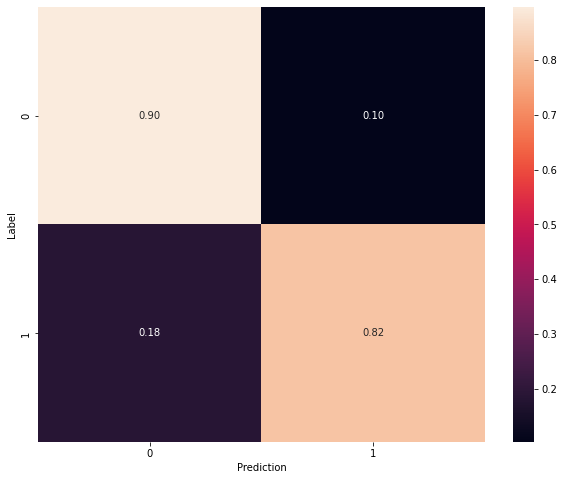

In [ ]:
confusion_mtx = confusion_matrix(list_label, list_predited_label, )
plt.figure(figsize=(10, 8))
cm = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, fmt='.2f')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### classification_report

In [ ]:
result = classification_report(list_label, list_predited_label, digits=6)
print(result)

              precision    recall  f1-score   support

           0   0.820554  0.945465  0.878592     22151
           1   0.924862  0.764512  0.837077     19449

    accuracy                       0.860865     41600
   macro avg   0.872708  0.854989  0.857835     41600
weighted avg   0.869320  0.860865  0.859183     41600

